<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
Analysis - Marginal plots</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

Model explanations only make sense if the models fit the data. One aspect of fit is the overall total loss. But it is difficult to tell whether a total logloss of, say, 550 is large or small or sufficient or insufficient. This notebook addresses the question if the models fit well, from two angles: calibration and marginal plots.

Since we use logloss as loss function, which is a [proper scoring rule](https://en.wikipedia.org/wiki/Scoring_rule), calibration should not be an issue. Indeed, the calibration diagram in section "Calibration" below shows the excellent calibration of all models.

The marginal plots of model predictions are a natural extension of the notebook "data_eda.ipynb". The plots also use the exactly same methodology. The three models (GLM, Tree and GBT) are fit and out-of-sample predictions are used for the plots. In particular, true conditional averages are shown and not partial dependencies.

Even though the plots are quire simple, it may not be straightforward to answer the question: Do the models fit well? One's assessment has to account at least for 
- the large number of variables and levels
- the different scales of the y-axes 
- the different underlying exposures, as evidenced by the confidence intervals
- the economic rationale of the business case to determine whether a difference is large or small.

But for many variables such as "Duration_Month", "Attained_Age", "Diagnosis_Category" and "OwnOccToAnyTransition" no systematic deviations are visible. There are some but limited differences between models, and to the raw probabilities, as is to be expected from the size of total loss and difference of it between models.

In [5]:
from glum import GeneralizedLinearRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss

from scipy.stats import beta

from IPython.display import display
import matplotlib.pyplot as plt
# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 

import gltd_utilities

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

# more CPUs is faster but then script may block PC, adjust accordingly
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import warnings

To run the notebook

* Adapt the path for the data file in the call of `load_gltd_data`, if necessary.
* Adapt pct to your requirements for anything between  $0.05\leq pct\leq1$. 
* Input 1 uses all data available, lower numbers the respective fraction. Below 0.05 predictions become somehwat volatile.

In [6]:
(X, Y, ID, nm_cat, nm_num, seed, rng) = gltd_utilities.load_gltd_data(
                                            "./", pct=1)
seed

'278913637497861371733928408738908383716'

In [7]:
# OHE DataFrame for tree
ct = ColumnTransformer(
        [("", OneHotEncoder(drop="first", sparse_output=False, dtype=int),
                        nm_cat)], 
        remainder="passthrough", verbose_feature_names_out=False)

X_ohe = ct.fit_transform(X)

# Set up CV which respects Study_ID groups
gss = GroupShuffleSplit(train_size=0.7, test_size=0.3,
                        random_state=rng.integers(low=0, high=1000))
trainidx, testidx = next(gss.split(X,groups=ID))

# note that data still contains Actual_Recoveries
xtrain, xtest = X.iloc[trainidx, :], X.iloc[testidx, :]
xtrain_ohe, xtest_ohe = X_ohe[trainidx, :], X_ohe[testidx, :]
ytrain, ytest = Y.iloc[trainidx], Y.iloc[testidx]

# Fit models

In [8]:
# GLM
ttlist = [var for var in nm_cat + nm_num]
fml = "~ " + "+".join(ttlist)

md = GeneralizedLinearRegressor(
            l1_ratio=0.0,
            alpha=1e-6,
            family="binomial", 
            link="logit",
            fit_intercept=True,
            drop_first=True,
            formula = fml
        )
        
md.fit(xtrain, ytrain)
# ergtbl contains all test data including the "Actual_Recoveries"
# and the model predictions
ergtbl = pd.concat([xtest.reset_index(drop=True), ytest.reset_index(drop=True)], axis=1)
ergtbl["phat_GLM"] = md.predict(xtest)

In [9]:
# GBT
md = HistGradientBoostingClassifier(
        interaction_cst = None,
        categorical_features="from_dtype",
        max_iter=1000,
        learning_rate=0.02,
        max_leaf_nodes=80,
        random_state=rng.integers(low=0, high=1000))

md.fit(xtrain,ytrain)
ergtbl["phat_GBT"] = md.predict_proba(xtest)[:,1]

In [10]:
# Tree
md = DecisionTreeClassifier(
            random_state=rng.integers(low=0, high=1000),
            max_depth=7, 
            criterion="log_loss"
            )
        
md.fit(xtrain_ohe, ytrain)
ergtbl["phat_Tree"] = md.predict_proba(xtest_ohe)[:,1]


In [11]:
nm_md = ["GLM", "GBT", "Tree"]

restbl = pd.DataFrame( {
    "loss":
    [log_loss(ergtbl["Actual_Recoveries"], ergtbl["phat_GLM"]),
    log_loss(ergtbl["Actual_Recoveries"], ergtbl["phat_GBT"]),
    log_loss(ergtbl["Actual_Recoveries"], ergtbl["phat_Tree"])] 
}, index = nm_md)
restbl.index.name = "model"
round(restbl * 100**2).astype(int)

,loss
model,
GLM,551
GBT,521
Tree,542


Recall from the notebook "rep_glm.ipynb" that the loss of the constant model was roughly 750.

# Calibration

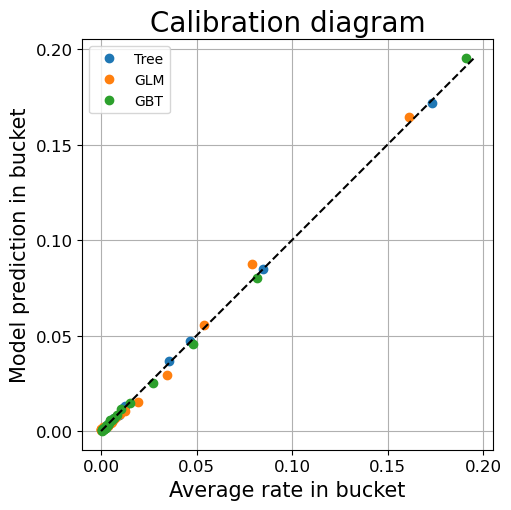

In [12]:
fig, ax = plt.subplots(layout="constrained", figsize=(5, 5))
nbin = 30
divisor = len(ergtbl) / (nbin)
curmax = 0.0
for (i, nm) in enumerate(["Tree", "GLM", "GBT"]):    
    nm_tmp = "phat_" + nm
    calidf = ergtbl[["Actual_Recoveries", nm_tmp]].sort_values(by=nm_tmp)
    calidf.reset_index(drop=True,inplace=True)
    calidf.reset_index(inplace=True)
    calidf["bucket"] = np.floor(calidf["index"] / divisor)
    plotdf = calidf.groupby("bucket", observed=True).agg(
        PYp = ("Actual_Recoveries", "mean"),
        p = (nm_tmp, "mean")
    )
    
    curmax = np.maximum(curmax, np.max(plotdf[["PYp", "p"]].to_numpy()))
    ax.plot(plotdf["p"], plotdf["PYp"], "o", label=nm)

ax.plot([0,curmax], [0,curmax], color = "black", linestyle="dashed")
ax.legend()
ax.set_ylabel("Model prediction in bucket")
ax.set_xlabel("Average rate in bucket")
ax.set_yticks(ax.get_xticks()[1:-1])
ax.set_title("Calibration diagram")
ax.grid()
plt.gca().set_aspect('equal', adjustable='box')

For further insights and background see the discussion of [calibration in Scikit-learn](https://scikit-learn.org/stable/modules/calibration.html) and the paper ["Model Comparison and Calibration Assessment: User Guide for Consistent Scoring Functions in Machine Learning and Actuarial Practice" by Fissler, Lorentzen, Mayer](https://arxiv.org/abs/2202.12780). 

# Marginal plots

## Helper functions

The two helper functions defined below estimate confidence intervals based on the binomial distribution and perform the actual aggregation, i.e. average the Actual Recoveries over the respective margins. 

In [13]:
def confi(n, k):
    """ Clopper-Person Confidence Interval for the binomial distribution
    
        see https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
    """

    if isinstance(n, pd.core.frame.DataFrame):
        n = n.to_numpy()
        k = k.to_numpy()

    alpha = 0.1
    # suppress division by zero warnings for empty levels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        p = k / n
        
    lo = np.zeros_like(p)
    hi = np.zeros_like(p)

    lo = beta.ppf(alpha/2, k, n - k + 1)
    hi = beta.ppf(1 - alpha/2, k + 1, n - k)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        hi[k == 0] = 1 - (alpha / 2) ** (1 / n[k==0])
        lo[k == n] = (alpha / 2) ** (1 / n[k==n])
    
    lo[k == 0] = 0
    hi[k==n] = 1

    return np.column_stack((p, lo, hi))

In [14]:
def rawrates(factor_list, data):
    """" Aggregate according to given factors
    
        Provides marginal aggregates, probabilities and confidence intervals
    """
    phat_columns = [col for col in data.columns if col.startswith("phat_")]
    aggregations = {"n": ("Actual_Recoveries", "count"), 
                    "k": ("Actual_Recoveries", "sum")}

    # Add aggregation functions for each "phat_" column
    for col in phat_columns:
        aggregations[col] = (col, "mean")

    # Group by factor_list and aggregate using the defined functions
    grouped = data[factor_list + ["Actual_Recoveries"] 
        + phat_columns].groupby(factor_list, as_index=False, observed=False)
    nk = grouped.agg(**aggregations)

    tmp = pd.DataFrame(confi(nk[["n"]], nk[["k"]]), columns=["p", "lo", "hi"])
    return(pd.concat([nk, tmp], axis=1))

## General marginal plots

This section generates the "one size fits all" generic marginal plots. For some inputs, in particular the numerical inputs, these will be refined later. In all plots the average predictions of the three models are shown together with the raw data and its confidence intervals.

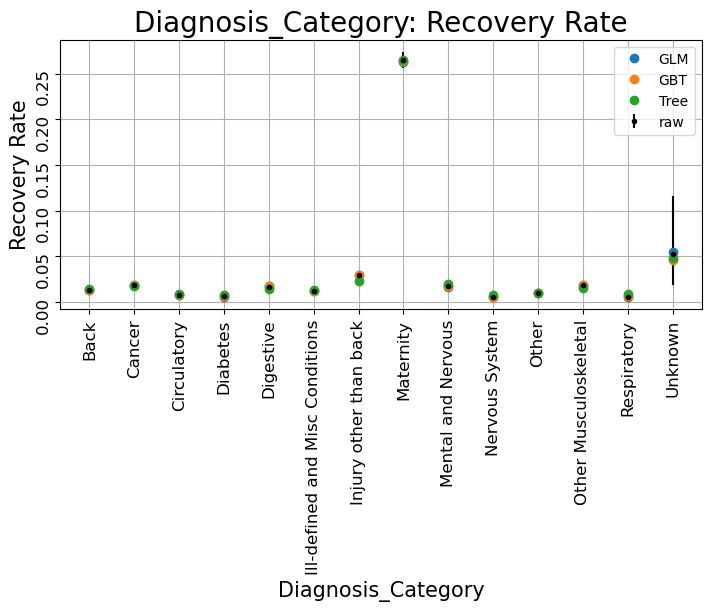

c:\Users\gg\miniconda3\envs\GLTD\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


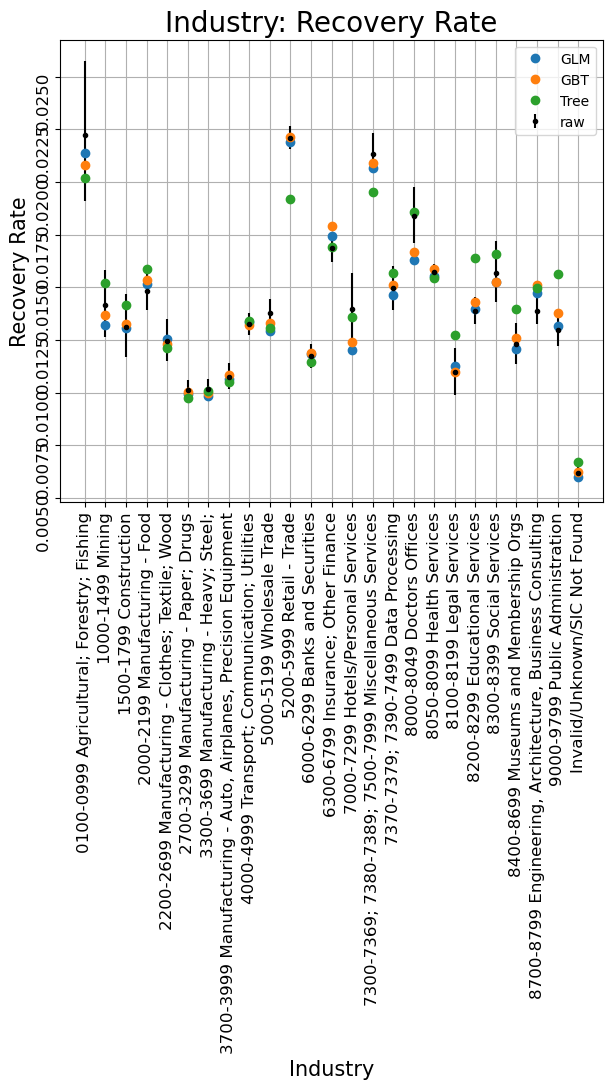

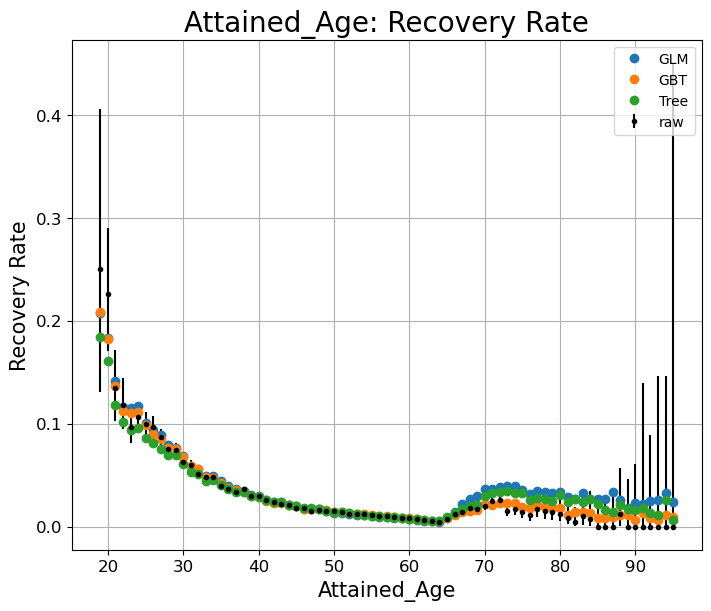

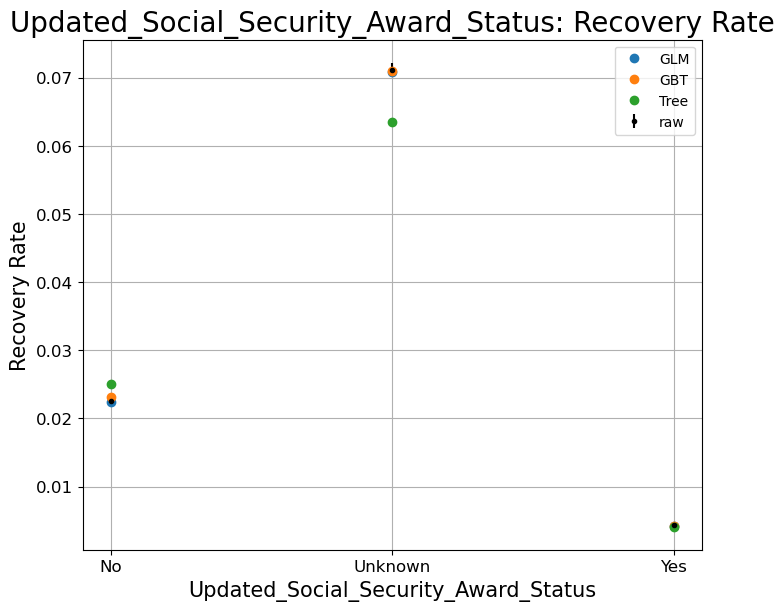

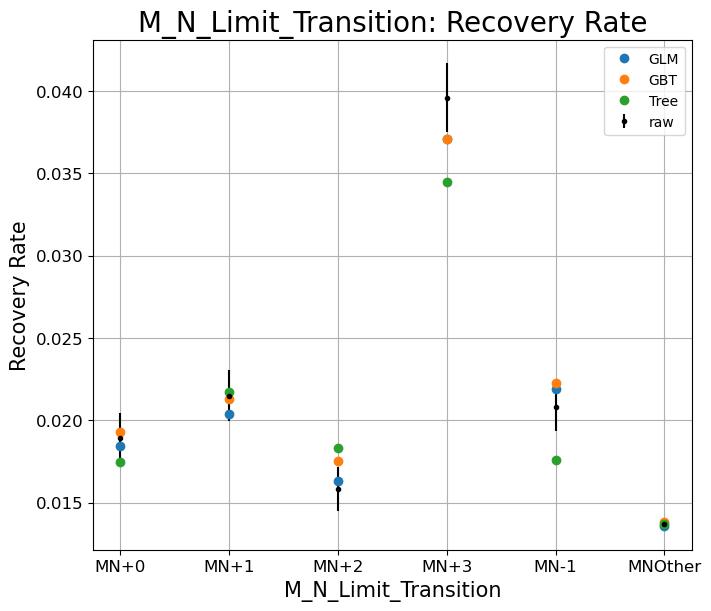

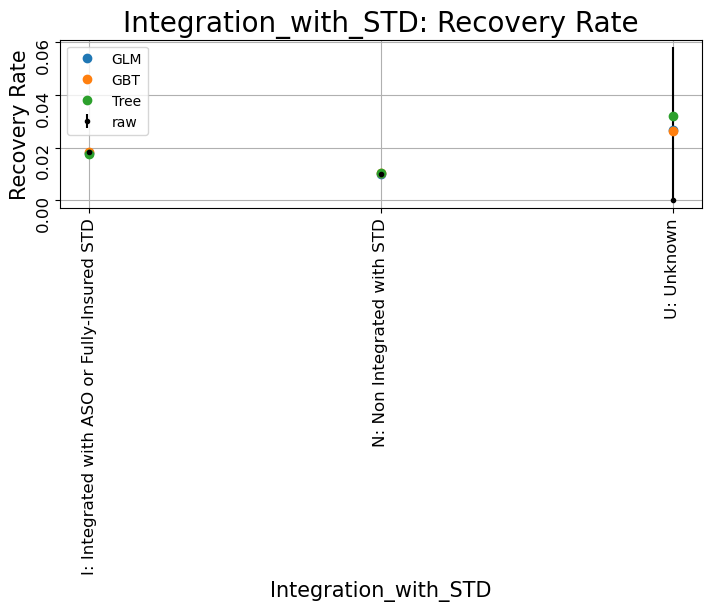

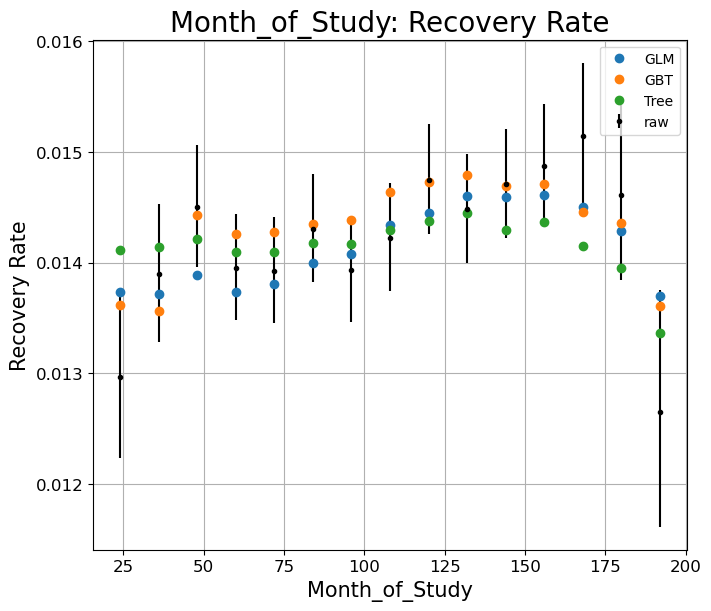

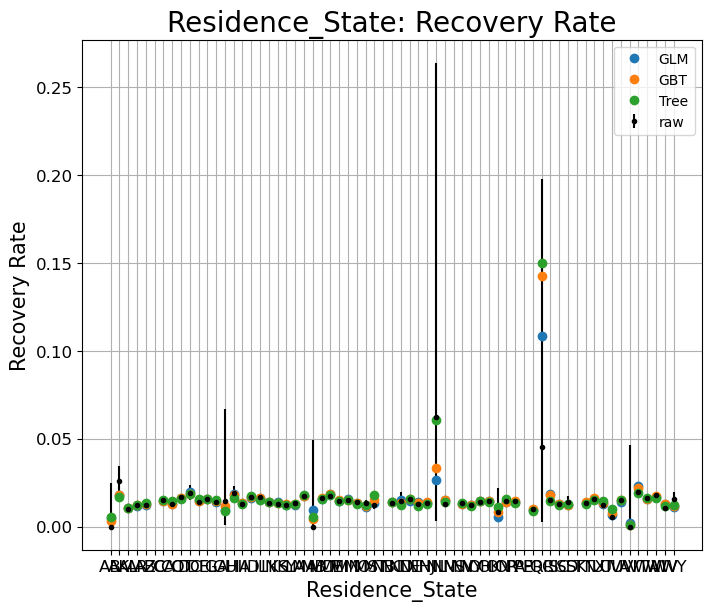

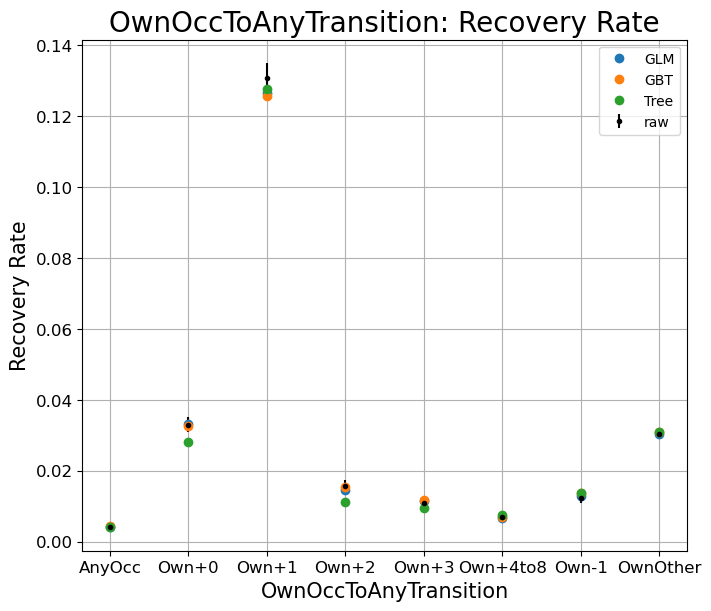

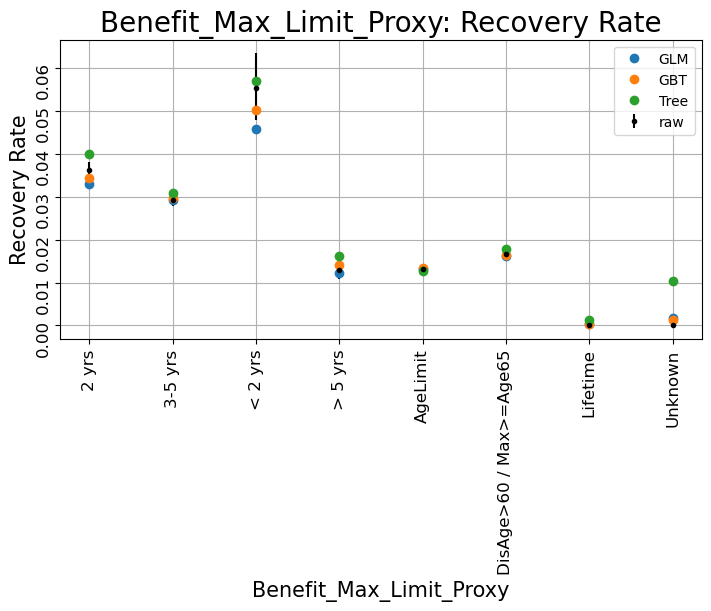

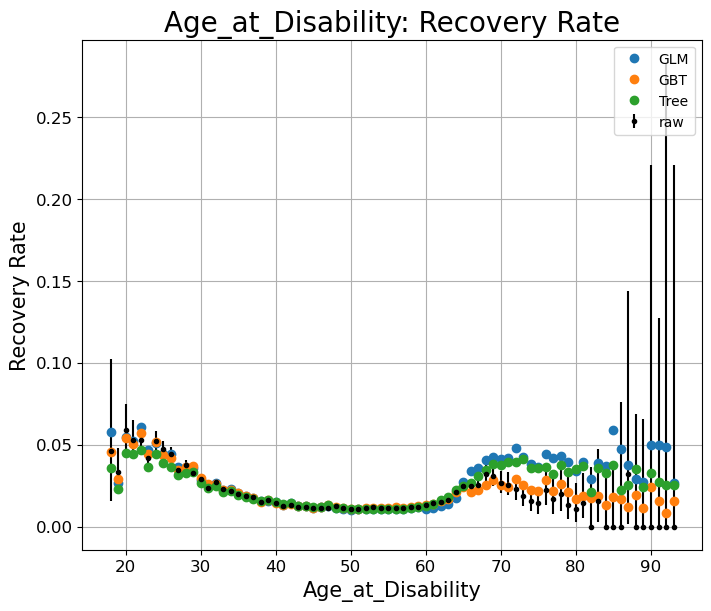

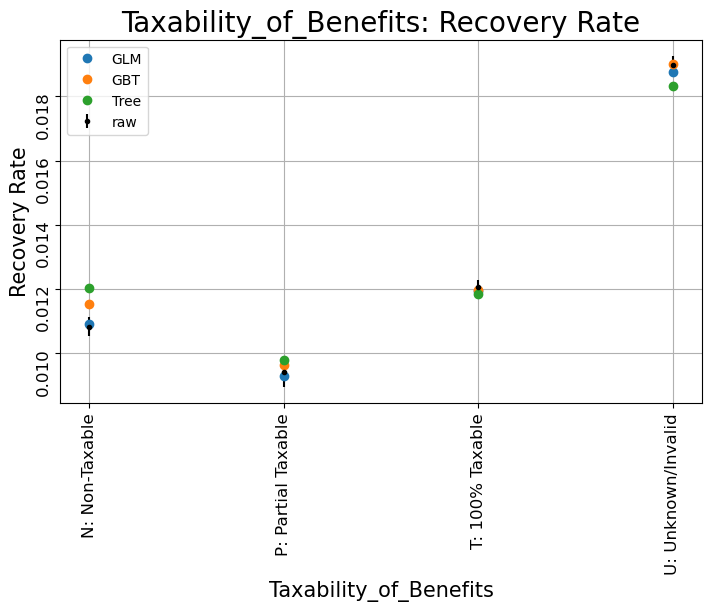

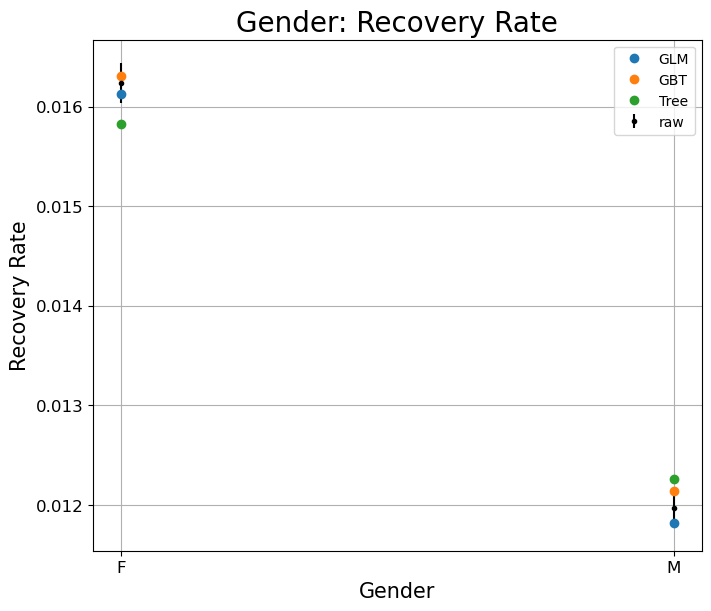

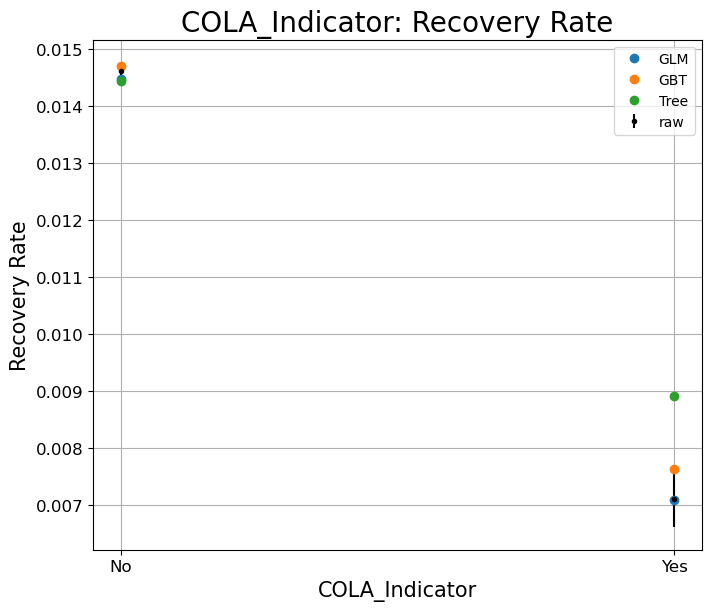

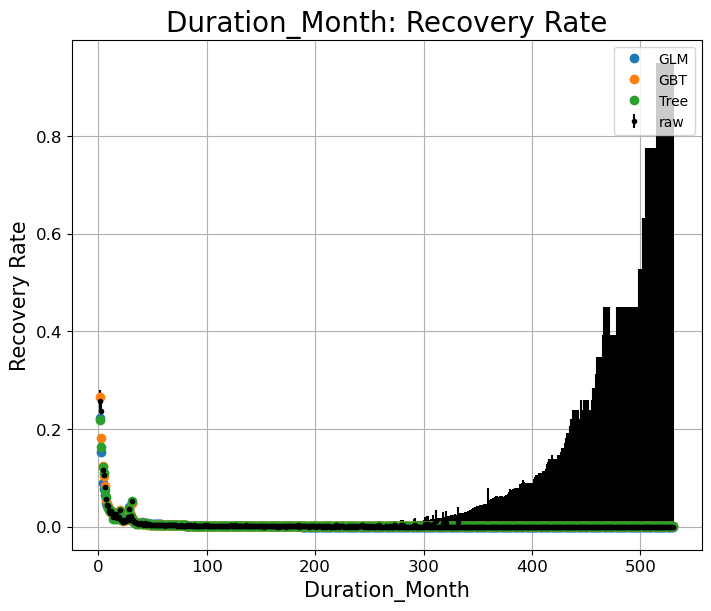

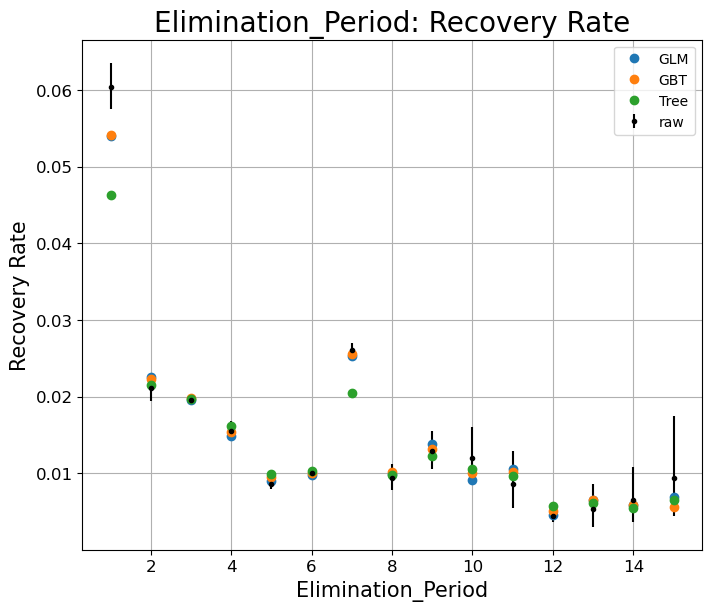

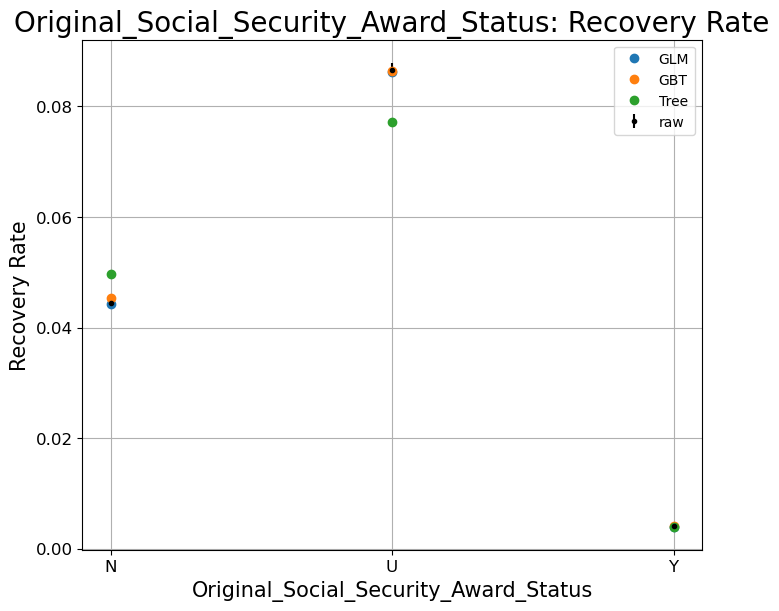

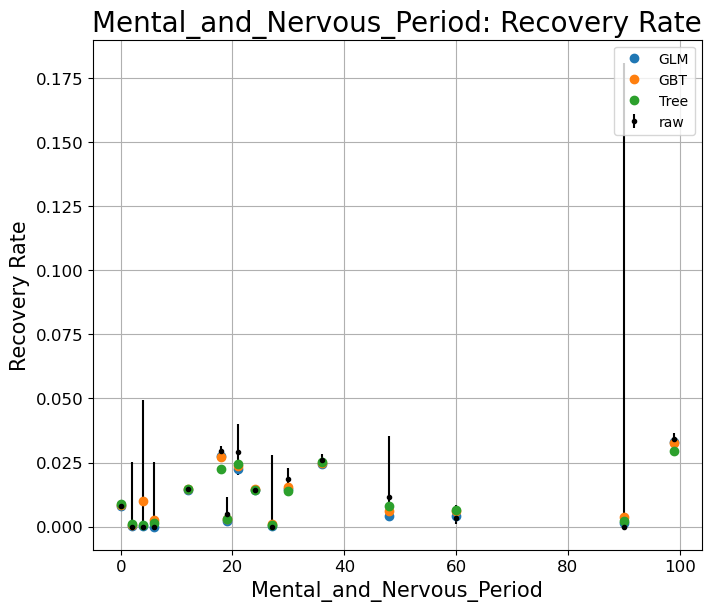

In [15]:
# factors which require special treatment
bincols = {"Gross_Indexed_Benefit_Amount", "Case_Size", 
           "Indexed_Monthly_Salary", "Replacement_Ratio"}

nm_disp = list(set(nm_cat) | set(nm_num) - bincols - {"Actual_Recoveries"})

# choose colourmap
cmap = plt.colormaps['tab10']

for fac in nm_disp:
    tt = rawrates([fac], ergtbl)
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(layout="constrained", figsize=(7, 6))

    ax.errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.k', linestyle='None', label="raw")
    
    for imd, nm in enumerate(nm_md):
        tmp = "phat_" + nm
        colour = cmap(imd)
        ax.plot(tt[fac], tt[tmp], "o", linestyle='None', color=cmap(imd), label=nm)

    xticks = ax.get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax.tick_params(labelrotation=90)

    ax.grid(True)
    ax.set_xlabel(fac)
    ax.set_ylabel('Recovery Rate')
    ax.legend()
    ax.set_title(fac + ": Recovery Rate")

    plt.show()

## Variables with special treatment

### Diagnosis category

Diagnosis category is presented again with restricted y-limits to exclude the exceptionally high maternity recoveries. 

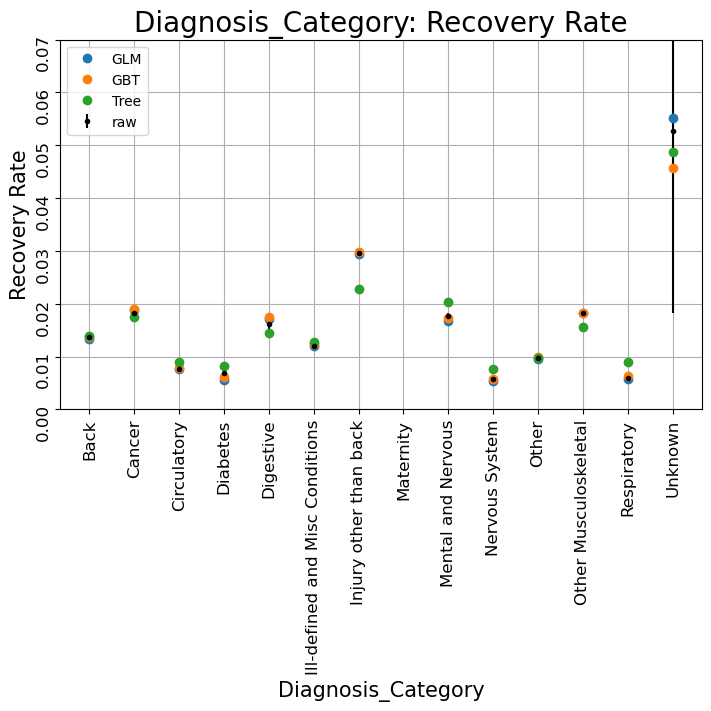

In [25]:
# cut recovery rate
fac = "Diagnosis_Category"
tt = rawrates([fac], ergtbl)
errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

fig, ax = plt.subplots(layout="constrained", figsize=(7, 7))

ax.errorbar(tt[fac], tt["p"], yerr=errbars, 
            fmt='.k', linestyle='None', label="raw")

for imd, nm in enumerate(nm_md):
    tmp = "phat_" + nm
    colour = cmap(imd)
    ax.plot(tt[fac], tt[tmp], "o", linestyle='None', color=cmap(imd), label=nm)

ax.set_ylim([0,0.07])
ax.tick_params(labelrotation=90)
ax.grid(True)
ax.set_xlabel(fac)
ax.set_ylabel('Recovery Rate')
ax.legend()
ax.set_title(fac + ": Recovery Rate")

plt.show()


### Replacement Ratio

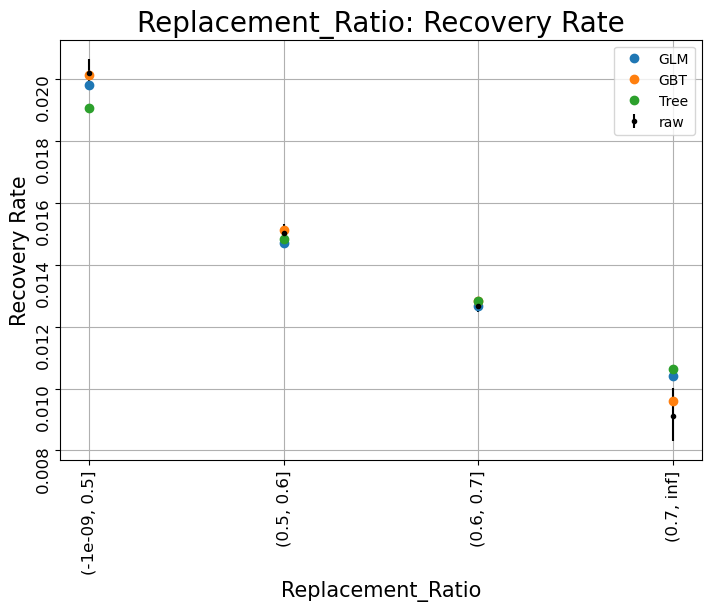

In [17]:
# cut recovery rate
fac = "Replacement_Ratio"
tmp =  pd.cut(ergtbl[fac], bins=[-1e-9, 0.5, 0.6, 0.7, np.inf]).astype(str)
phat_columns = [col for col in ergtbl.columns if col.startswith("phat_")]
tmptbl = pd.concat([ergtbl[["Actual_Recoveries"] + phat_columns], tmp], axis=1)
tt = rawrates([fac], tmptbl)
errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

fig, ax = plt.subplots(layout="constrained", figsize=(7, 6))

ax.errorbar(tt[fac], tt["p"], yerr=errbars, 
            fmt='.k', linestyle='None', label="raw")

for imd, nm in enumerate(nm_md):
        tmp = "phat_" + nm
        colour = cmap(imd)
        ax.plot(tt[fac], tt[tmp], "o", linestyle='None', color=cmap(imd), label=nm)

xticks = ax.get_xticklabels()
maxllen = max(len(label.get_text()) for label in xticks)
if maxllen > 9:
    ax.tick_params(labelrotation=90)

ax.grid(True)
ax.set_xlabel(fac)
ax.set_ylabel('Recovery Rate')
ax.legend()
ax.set_title(fac + ": Recovery Rate")

plt.show()

### Monetary indicators

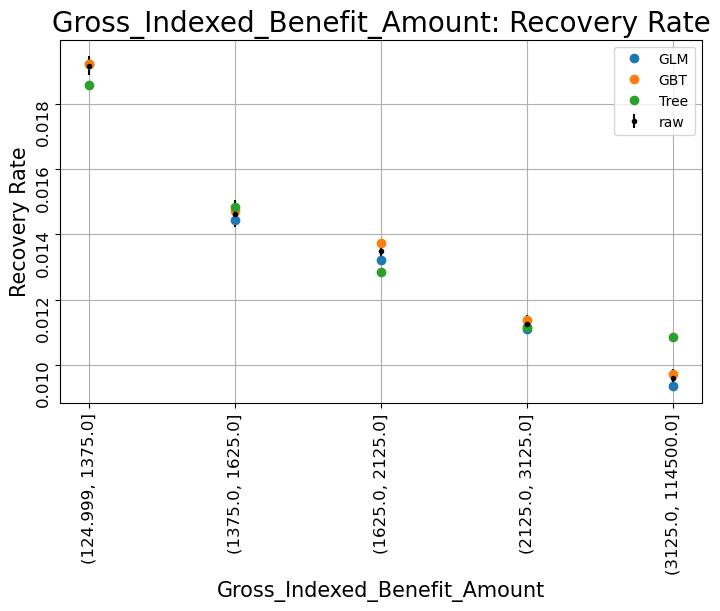

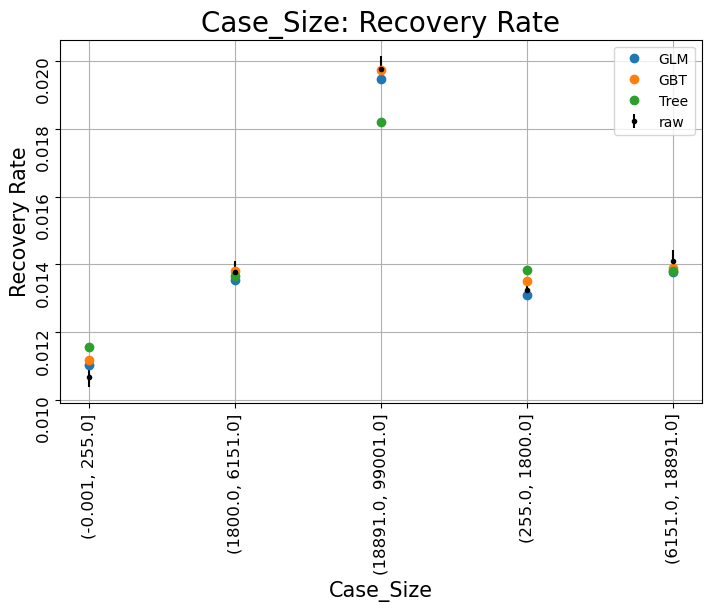

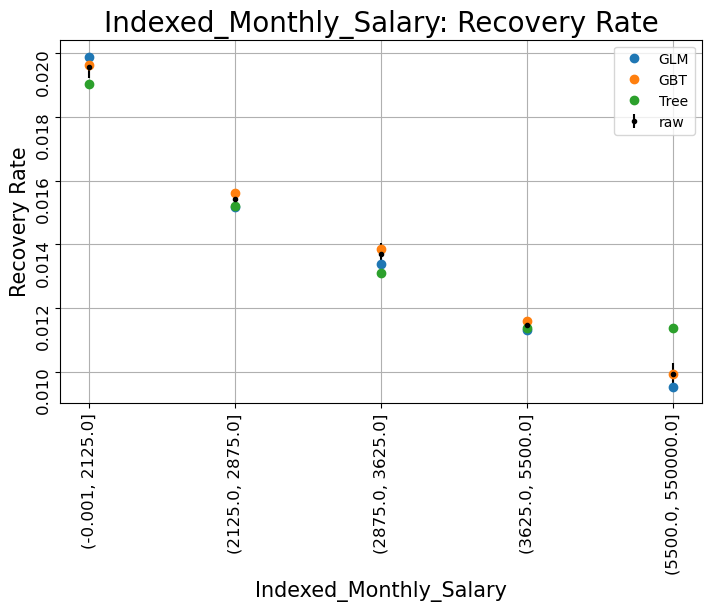

In [18]:
# bin monetary values
bincols = ["Gross_Indexed_Benefit_Amount", "Case_Size", "Indexed_Monthly_Salary"]

for fac in bincols:
    tmp = pd.qcut(ergtbl[fac], 5, retbins=True, duplicates="drop")[0]
    tmp =  tmp.astype(str)
    tmptbl = pd.concat([ergtbl[["Actual_Recoveries"] + phat_columns], tmp], axis=1)
    tt = rawrates([fac], tmptbl)
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(layout="constrained", figsize=(7, 6))

    ax.errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.k', linestyle='None', label="raw")

    for imd, nm in enumerate(nm_md):
        tmp = "phat_" + nm
        colour = cmap(imd)
        ax.plot(tt[fac], tt[tmp], "o", linestyle='None', color=cmap(imd), label=nm)

    xticks = ax.get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax.tick_params(labelrotation=90)

    ax.grid(True)
    ax.set_xlabel(fac)
    ax.set_ylabel('Recovery Rate')
    ax.legend()
    ax.set_title(fac + ": Recovery Rate")

    plt.show()

### Zoom in

For some variables the x-axis is rescaled to provide better visibility.

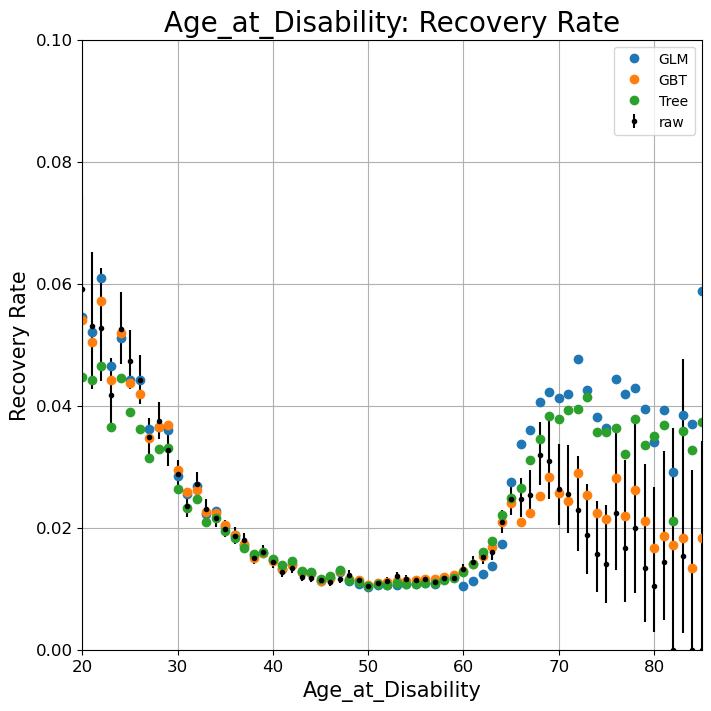

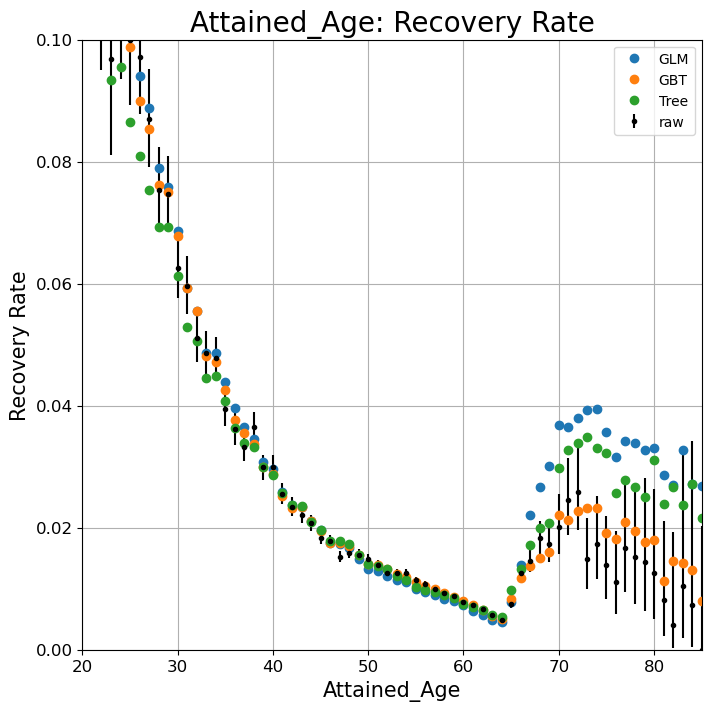

In [19]:
# cols to zoom in
zoomcols = ["Age_at_Disability", "Attained_Age"]
for fac in zoomcols:
    tt = rawrates([fac], ergtbl)
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(layout="constrained", figsize=(7, 7))

    ax.errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.k', linestyle='None', label="raw")
    
    for imd, nm in enumerate(nm_md):
        tmp = "phat_" + nm
        colour = cmap(imd)
        ax.plot(tt[fac], tt[tmp], "o", linestyle='None', color=cmap(imd), label=nm)
    
    ax.set_xlim([20,85])
    ax.set_ylim([0,0.1])
    
    ax.grid(True)
    ax.set_xlabel(fac)
    ax.set_ylabel('Recovery Rate')
    ax.legend()
    ax.set_title(fac + ": Recovery Rate")

    plt.show()

Observations:
While the general decrease of recovery probability with age is well in line with actuarial experience, the marked increase from Attained_Age >= 65 is surprising.

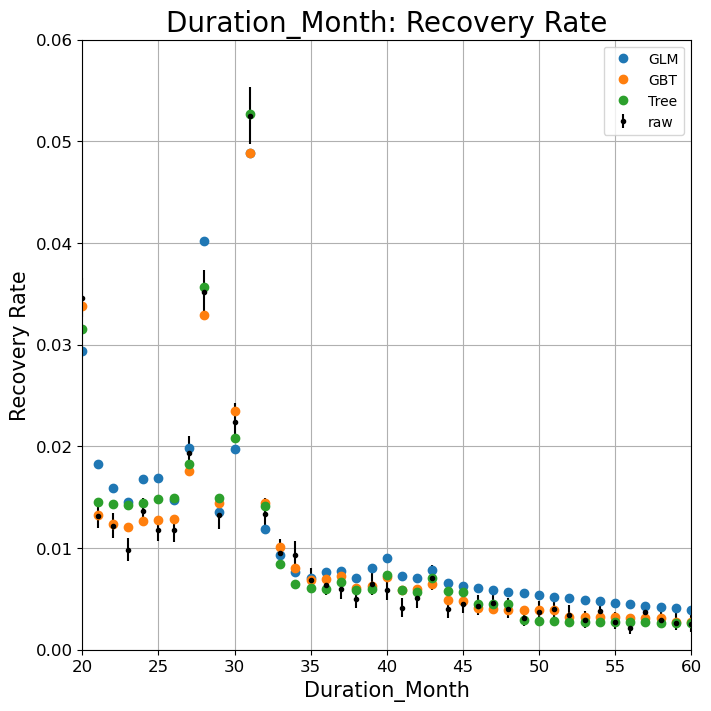

In [20]:
# cols to zoom in
zoomcols = ["Duration_Month"]
for fac in zoomcols:
    tt = rawrates([fac], ergtbl)
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(layout="constrained", figsize=(7, 7))

    ax.errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.k', linestyle='None', label="raw")

    for imd, nm in enumerate(nm_md):
        tmp = "phat_" + nm
        colour = cmap(imd)
        ttmp = tt[fac] + np.random.normal(0, 0.05, size=tt[fac].shape)
        ax.plot(tt[fac], tt[tmp], "o", linestyle='None', color=cmap(imd), label=nm)
    
    ax.set_xlim([20,60])
    ax.set_ylim([0,0.06])
    
    ax.grid(True)
    ax.set_xlabel(fac)
    ax.set_ylabel('Recovery Rate')
    ax.legend()
    ax.set_title(fac + ": Recovery Rate")

    plt.show()

The general trend of less recovery with longer duration is in-line with expectation. The complexities between durations 25 to 35 are most likely the result of product features such as disability definitions, own versus any occupation.  